In [22]:

#%pip install rasterio matplotlib shapely geopandas albumentations
#%pip install torch torchvision torchgeo  --index-url https://download.pytorch.org/whl/cu121
# Import necessary libraries

import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import Point, box
from PIL import Image, ImageDraw
import numpy as np
import os
import matplotlib.pyplot as plt
import albumentations as A
import random

In [4]:
dataset = rasterio.open("../data/Kazcrop_merged.tif")
# Read the image data

# Read all bands into a (bands, height, width) numpy array
image = dataset.read()  # Shape: (4, height, width)
print("Image shape:", image.shape)

Image shape: (4, 18915, 17829)


In [5]:
def normalize_image_bands(image_array):
    normalized_image = image_array.astype(np.float32)
    for band_index in range(normalized_image.shape[0]):
        band = normalized_image[band_index]
        min_value = np.min(band)
        max_value = np.max(band)
        if max_value > min_value:  # Avoid division by zero
            normalized_image[band_index] = (band - min_value) / (max_value - min_value)
        else:
            normalized_image[band_index] = 0  # or some fallback
    return normalized_image

normalized_image = normalize_image_bands(image)
print(normalized_image.shape[0])

4


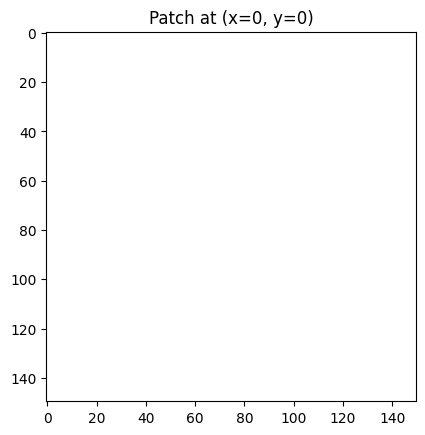

In [9]:
# Sliding window generator to extract patches from the image
def sliding_window_generator(image_array, window_size, stride):
    """
    Yield patches of shape (channels, height, width) from a 3D image tensor.
    """
    channels, height, width = image_array.shape
    window_height, window_width = window_size

    for y_start in range(0, height - window_height + 1, stride):
        for x_start in range(0, width - window_width + 1, stride):
            patch = image_array[:, y_start:y_start + window_height, x_start:x_start + window_width]
            yield patch, (x_start, y_start)


# Example usage of the sliding window generator
patch_window_size = (150, 150)  # Size of the patches
patch_stride = 75  # Stride for the sliding window

patches = list(sliding_window_generator(normalized_image, patch_window_size, patch_stride))

for index in range(1):
    patch, (x_offset, y_offset) = patches[index]
    rgb_patch = patch[[2, 1, 0]]  # Red, Green, Blue bands
    rgb_patch = np.transpose(rgb_patch, (1, 2, 0))  # Change to (height, width, channels)
    plt.imshow(rgb_patch)
    plt.title(f"Patch at (x={x_offset}, y={y_offset})")
    plt.show()

In [10]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 3070


In [20]:
# Load GeoJSON with 'geometry', 'center_x', 'center_y', 'max_dim'
gdf = gpd.read_file("../data/bounding_boxes.geojson")

# Open raster
src = rasterio.open("../data/Kazcrop_merged.tif")

# Output dirs
os.makedirs("patches/images", exist_ok=True)
os.makedirs("patches/masks", exist_ok=True)

# Augmentations to apply to both image and mask
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
], additional_targets={"mask": "mask"})

for idx, row in gdf.iterrows():
    bbox_geom = row.geometry
    center_x, center_y = row["center_x"], row["center_y"]
    diameter = row["max_dim"]  # In meters = pixels

    # Crop patch from raster
    patch_img, patch_transform = mask(src, [bbox_geom], crop=True)
    patch_img = np.moveaxis(patch_img, 0, -1)  # Channels last (H, W, C)

    # Get patch dimensions
    h, w = patch_img.shape[:2]

    # Convert center point to pixel coordinates and add jitter to diameter
    x_px, y_px = (~patch_transform) * (center_x, center_y)
    x_px, y_px = int(x_px), int(y_px)
    jitter_factor = random.uniform(0.9, 1.1)
    jittered_diameter = diameter * jitter_factor
    r = int(jittered_diameter / 2)

    # Create binary mask
    mask_img = Image.new("L", (w, h), 0)
    draw = ImageDraw.Draw(mask_img)
    draw.ellipse([x_px - r, y_px - r, x_px + r, y_px + r], fill=1)
    mask_array = np.array(mask_img, dtype=np.uint8)

    # Apply augmentation
    augmented = augment(image=patch_img, mask=mask_array)
    patch_img_aug = augmented["image"]
    mask_aug = augmented["mask"]

    # Save as .npy
    np.save(f"patches/images/patch_{idx}.npy", patch_img_aug)
    np.save(f"patches/masks/mask_{idx}.npy", mask_aug)

print("✅ Image patches and masks saved with augmentations.")

✅ Image patches and masks saved with augmentations.


In [23]:
# Load data
gdf = gpd.read_file("../data/bounding_boxes.geojson")
src = rasterio.open("../data/Kazcrop_merged.tif")

# Output dirs
os.makedirs("patches", exist_ok=True)
os.makedirs("masks", exist_ok=True)

# Group by size_bucket
for bucket_size, group in gdf.groupby("size_bucket"):
    print(f"Processing size bucket: {bucket_size}")

    # Use the median buffer from the group as patch half-size
    patch_half = int(group["buffer"].median())

    # Avoid overlap with positive areas
    feature_union = group.buffer(10).geometry.union_all()

    # Raster bounds
    minx, miny, maxx, maxy = src.bounds

    # === POSITIVE PATCHES ===
    for idx, row in group.iterrows():
        bbox_geom = row.geometry
        center_x, center_y = row["center_x"], row["center_y"]
        diameter = row["max_dim"]

        try:
            patch_img, patch_transform = mask(src, [bbox_geom], crop=True)
        except Exception as e:
            print(f"Skipping idx {idx} due to error: {e}")
            continue

        patch_img = np.moveaxis(patch_img, 0, -1)
        patch_img = np.nan_to_num(patch_img, nan=0)
        patch_img = np.clip(patch_img, 0, 255).astype(np.uint8)

        # Save image
        Image.fromarray(patch_img).save(f"patches/pos_patch_{bucket_size}_{idx}.tif")

        # Convert center to pixel coordinates
        x_px, y_px = (~patch_transform) * (center_x, center_y)
        x_px, y_px = int(x_px), int(y_px)

        # Jittered radius
        jitter = random.uniform(-0.1, 0.1) * diameter
        r = int((diameter + jitter) / 2)

        # Create mask
        h, w = patch_img.shape[:2]
        mask_img = Image.new("L", (w, h), 0)
        draw = ImageDraw.Draw(mask_img)
        draw.ellipse([x_px - r, y_px - r, x_px + r, y_px + r], fill=255)
        mask_img.save(f"masks/pos_mask_{bucket_size}_{idx}.tif")

    # === NEGATIVE PATCHES ===
    num_negatives = len(group) * 2
    for i in range(num_negatives):
        attempts = 0
        while True:
            attempts += 1
            x = random.uniform(minx + patch_half, maxx - patch_half)
            y = random.uniform(miny + patch_half, maxy - patch_half)
            patch_bbox = box(x - patch_half, y - patch_half, x + patch_half, y + patch_half)

            if not patch_bbox.intersects(feature_union):
                break
            if attempts > 1000:
                print("Warning: couldn't find non-overlapping patch.")
                break

        try:
            patch_img, _ = mask(src, [patch_bbox], crop=True)
        except Exception as e:
            print(f"Skipping negative patch {i} due to error: {e}")
            continue

        patch_img = np.moveaxis(patch_img, 0, -1)
        patch_img = np.nan_to_num(patch_img, nan=0)
        patch_img = np.clip(patch_img, 0, 255).astype(np.uint8)

        Image.fromarray(patch_img).save(f"patches/neg_patch_{bucket_size}_{i}.tif")

        h, w = patch_img.shape[:2]
        mask_img = Image.new("L", (w, h), 0)
        mask_img.save(f"masks/neg_mask_{bucket_size}_{i}.tif")

Processing size bucket: large
Processing size bucket: medium
Processing size bucket: small
